In [3]:

import os
import pandas as pd
import numpy as np
import seaborn  as sns
from plotnine import *
import random
import warnings

from IPython.display import Image

from functools import partial

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mqloss

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape

from statsforecast import StatsForecast
from statsforecast.models import SklearnModel
from statsforecast.utils import ConformalIntervals
from statsforecast.models import (
    WindowAverage,
    Naive,
    SeasonalNaive,
    RandomWalkWithDrift,
    HistoricAverage,
)

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

# Chapter 5: The forecaster's toolbox
## 5.2. Some simple forecasting methods 

In practice, simple methods are only useful a references. 

### Mean method 

Forecasts of all future values ($T + h$) are set to be the average of all previous values. 

$$
\hat{y}_{T+h|T} = \bar{y} = \frac{(y_1 + ... + y_T)}{T}
$$

### Naïve method

Each forecast is set to the previous value. 

$$
\hat{y}_{T+h|T} = y_T
$$

### Seasonal naïve method 

Each forecast is set to its value in the prior period of last season. For example, a prediction for a Monday on weekly data would be the value on the prior Monday. Mathematically, the value for the next prediction given all previous $T$ observations, $T + h|T$, is the value from the same $m$ season from the last period, which is defined as the number of complete seasons that have elapsed ($m(k+1)$, where the integer of $k=(k-1)/m$ and is taken). 

$$
\hat{y}_{T+h|T} = y_{T+h - m(k+1)}
$$

### Drift method

Forecasts are set to the average change observed over the entire course of the time series. 

$$
\hat{y}_{T+h|T}  = y_{T+h} + h \Big(\frac{y_t - y_1}{T -1}\Big)
$$

/var/folders/89/k8gtyblx5nj1gsmlk919bct80000gn/T/ipykernel_16196/511585597.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


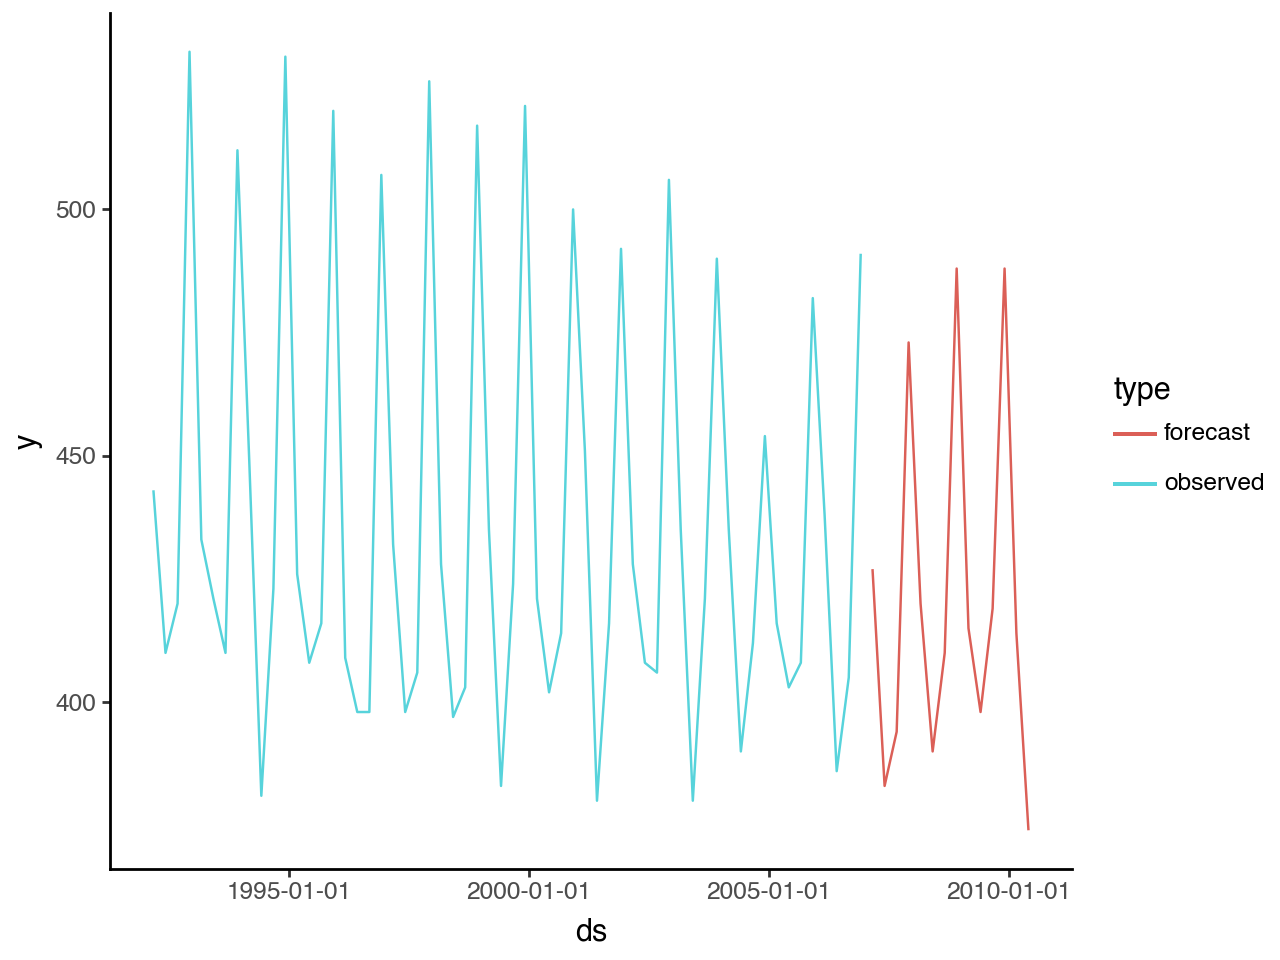

In [25]:
df_aus_beer = pd.read_csv('data/raw/aus_production_formatted.csv')

beers_df = df_aus_beer.query("unique_id == 'Beer' and ds >= '1992-01-01'")
df_train = beers_df[:-14]
df_test = beers_df[-14:]

avg_method = HistoricAverage()
naive_method = Naive()
seasonal_naive_method = SeasonalNaive(4)

sf = StatsForecast(
    models=[avg_method, naive_method, seasonal_naive_method], 
    freq=pd.offsets.QuarterBegin(1)
)
sf.fit(df_train)

df_forecast = sf.predict(h=14)
df_forecast["y"] = df_test["y"].values

df_train['type'] = 'observed'
df_forecast['type'] = 'forecast'

df_merged = pd.concat(objs=[df_train, df_forecast], ignore_index=True)
df_merged['ds'] = pd.to_datetime(df_merged['ds'])

(ggplot(data=df_merged, mapping=aes(x='ds', y='y', group='type', color='type')) + 
 geom_line() + 
 theme_classic())

In [26]:
df_forecast

,unique_id,ds,HistoricAverage,Naive,SeasonalNaive,y,type
0,Beer,2007-03-01,436.45,491.0,438.0,427.0,forecast
1,Beer,2007-06-01,436.45,491.0,386.0,383.0,forecast
2,Beer,2007-09-01,436.45,491.0,405.0,394.0,forecast
3,Beer,2007-12-01,436.45,491.0,491.0,473.0,forecast
4,Beer,2008-03-01,436.45,491.0,438.0,420.0,forecast
5,Beer,2008-06-01,436.45,491.0,386.0,390.0,forecast
6,Beer,2008-09-01,436.45,491.0,405.0,410.0,forecast
7,Beer,2008-12-01,436.45,491.0,491.0,488.0,forecast
8,Beer,2009-03-01,436.45,491.0,438.0,415.0,forecast
9,Beer,2009-06-01,436.45,491.0,386.0,398.0,forecast
